In [ ]:
import os
import torch
import torchaudio
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torch import nn, save, load
from torch.optim import Adam
import torchvision
from torch.utils.data import Dataset, DataLoader
from scipy import signal
from PIL import Image
from scipy.io import wavfile
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa, librosa.display
# from SupCon.losses import SupConLoss  # Assuming you have a SupConLoss function defined

In [146]:
DPI=115
figuresize=(2.6,2.6)
img_size=(299,299)
hop_length=1
n_fft = 2048 
sr=8000
repeat=2
Batch_size=50
learn_rate = 0.01
Momentum=0.9
num_epochs=1

In [147]:
import librosa
import librosa.display
from PIL import Image

class MyDataset:
    def __init__(self, list_of_audio_files, labels, transform=None):
        self.list_of_audio_files = list_of_audio_files
        self.transform = transform
        self.labels = labels

    def __len__(self):
        return len(self.list_of_audio_files)

    def __getitem__(self, idx):
        audio_file = os.path.join("/kaggle/input/spr-splitevents", self.list_of_audio_files[idx])
        samples, sample_rate = librosa.load(audio_file, sr=None)
        spectrogram = librosa.stft(samples)
        spectrogram = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
        
        # Convert the spectrogram to an image
        fig, ax = plt.subplots(1, 1, figsize=figuresize, dpi=DPI)
        ax.axis('off')
        img = librosa.display.specshow(spectrogram, ax=ax, cmap='gray')
        fig.savefig('spectrogram.png', bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        
        img = Image.open('spectrogram.png').convert('RGB')
        img = img.resize(img_size)  # Resize the image to 224x224 pixels
        img = np.array(img)
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [148]:
df =pd.read_csv("/kaggle/input/spr-splitevents/events_processed (1).csv")
# df =df.reset_index(drop=True)
train_val, test = train_test_split(df, test_size=0.2)
train,val = train_test_split(train_val, test_size=0.1)
train =train.reset_index(drop=True)
val =val.reset_index(drop=True)
test =test.reset_index(drop=True)

In [149]:
trainset = MyDataset(train["event_path"],train["type"],transform=torchvision.transforms.ToTensor())
valset = MyDataset(val["event_path"],val["type"],transform=torchvision.transforms.ToTensor())
testset= MyDataset(test["event_path"],test["type"],transform=torchvision.transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=Batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=Batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=Batch_size, shuffle=True)

In [189]:
import torch
import torch.nn as nn
from torchvision.models import inception_v3, Inception_V3_Weights

# Load pre-trained Inception-ResNet v3 with updated parameter
model = inception_v3(weights=Inception_V3_Weights.DEFAULT)

# Freeze the pre-trained layers (optional)
for param in base_model.parameters():
    param.requires_grad = False

class Identity(nn.Module):
    def __init__(self):
        super(Identity,self).__init__()
    def forward(self,x):
        return x
    
# Modify the initial convolutional layer
model.Conv2d_1a_3x3.conv = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=2, padding=1)


# Move the model to GPU if available
if torch.cuda.is_available():
    model.to('cuda')


# Define a loss function and an optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate, momentum=Momentum)



In [185]:
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), 

In [190]:
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probs = []  # Store predicted probabilities
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())  # Get probabilities for class 1
    return 100 * correct / total, np.array(all_labels), np.array(all_predictions), np.array(all_probs)

In [191]:
# Training and validation
train_accuracies = []
val_accuracies = []

In [192]:
import pytorch_lightning as pl

# Instantiate a Trainer
trainer = pl.Trainer(
    max_epochs=1,  # Number of training epochs
    devices=1,         # Number of GPUs to use (if available)
    callbacks=[pl.callbacks.EarlyStopping(monitor='val_loss')],  # Early stopping
    logger=pl.loggers.TensorBoardLogger('logs/'),  # Logging setup
)

# Training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        logits = outputs.logits

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        loop.set_postfix(loss=loss.item())
        # Print accuracy after each epoch
    train_acc = 100 * correct / total
    train_accuracies.append(accuracy)
    val_acc, val_labels, val_preds,val_probs = calculate_accuracy(valloader, model)
    val_accuracies.append(val_acc)
    print(f'Train Accuracy: {train_acc}%, Validation Accuracy: {val_acc}%')
    

# Testing phase (if needed)
# trainer.test(dataloaders=test_dataloaders)


Epoch 1/1
Train Accuracy: 72.38372093023256%, Validation Accuracy: 63.83442265795207%


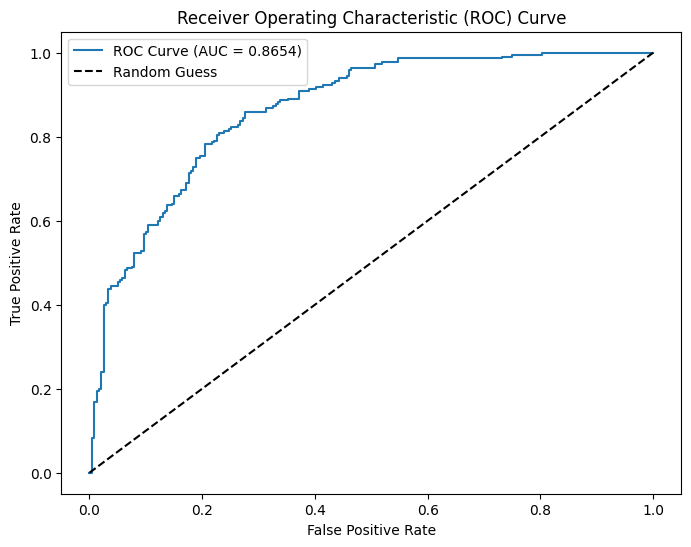

              precision    recall  f1-score   support

      normal       0.96      0.32      0.48       239
    ubnormal       0.57      0.99      0.72       220

    accuracy                           0.64       459
   macro avg       0.77      0.65      0.60       459
weighted avg       0.77      0.64      0.60       459



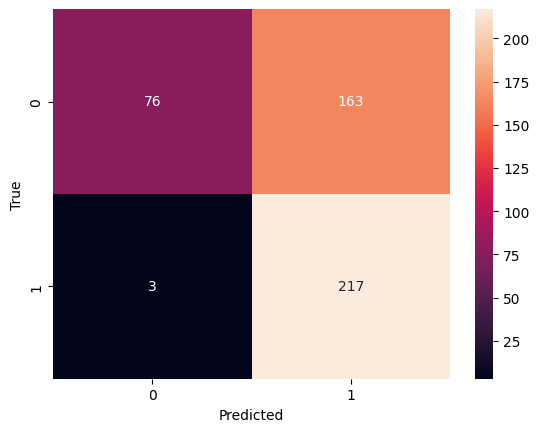

In [193]:
# Plotting the training and validation accuracy
'''plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()'''

# Compute ROC curve
fpr, tpr, threshold = roc_curve(val_labels, val_probs)
roc_auc = roc_auc_score(val_labels, val_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Printing the classification report
print(classification_report(val_labels, val_preds, target_names=['normal', 'ubnormal']))

# Printing the confusion matrix
cm = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

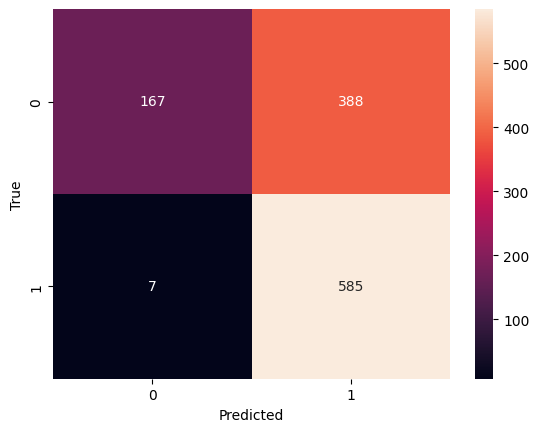

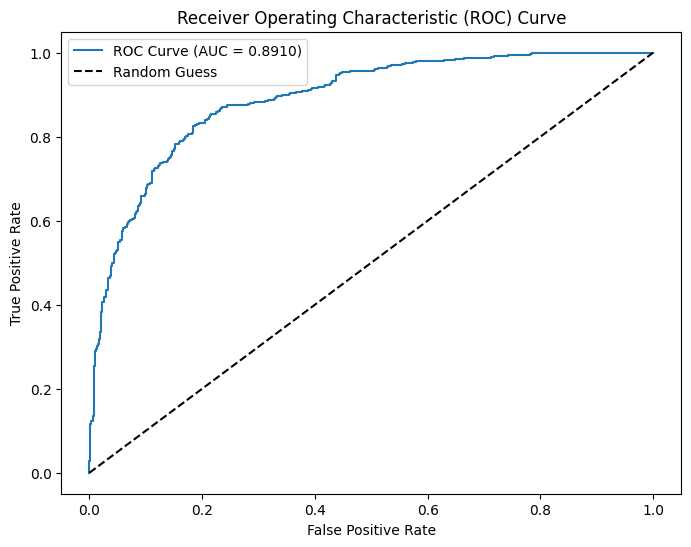

              precision    recall  f1-score   support

      normal       0.96      0.32      0.48       239
    abnormal       0.57      0.99      0.72       220

    accuracy                           0.64       459
   macro avg       0.77      0.65      0.60       459
weighted avg       0.77      0.64      0.60       459



In [205]:
# Printing the confusion matrix
test_acc, test_labels, test_preds,test_prob = calculate_accuracy(testloader, model)
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# Compute ROC curve
fpr, tpr, threshold = roc_curve(test_labels, test_prob)
roc_auc = roc_auc_score(test_labels, test_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Printing the classification report
print(classification_report(val_labels, val_preds, target_names=['normal', 'abnormal']))

In [206]:
with open('2.pt', 'wb') as f: 
    save(model.state_dict(), f) 


with open('2.pt', 'rb') as f: 
    model.load_state_dict(load(f))  
test.to_csv("model.csv")